In [1]:
import numpy as np
from PIL import Image

filename = "./test/rain.jpg"
pixels = np.asarray(Image.open(filename))

In [62]:
from instapy.python_filters import *
from instapy.numpy_filters import *
grayscale_image_py= python_color2sepia(pixels)
grayscale_image_np = numpy_color2sepia(pixels,0.5)
np.where(np.not_equal(grayscale_image_py,grayscale_image_np)==True)

(array([  0,   0,   0, ..., 399, 399, 399]),
 array([  0,   0,   0, ..., 599, 599, 599]),
 array([0, 1, 2, ..., 0, 1, 2]))

In [27]:
ineq = np.not_equal(grayscale_image_py,grayscale_image_np)
np.where(ineq[:,:,2]==False)

(array([ 27,  27,  27, ..., 399, 399, 399]),
 array([429, 430, 440, ..., 508, 519, 523]))

In [13]:
sepia_matrix = np.add(np.asarray([[1.0, 0, 0], [0, 1, 0], [0, 0, 1]]) * 0.5,np.asarray(
        [
            [0.393, 0.769, 0.189],
            [0.349, 0.686, 0.168],
            [0.272, 0.534, 0.131],
        ],
    )* 0.5)
sepia_matrix

array([[0.6965, 0.3845, 0.0945],
       [0.1745, 0.843 , 0.084 ],
       [0.136 , 0.267 , 0.5655]])

In [4]:
grayscale_image_np[185,558,:]

array([253, 225, 176], dtype=uint8)

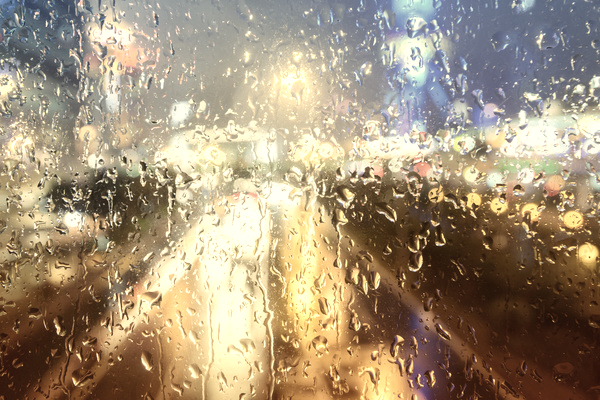

In [4]:
from instapy.numpy_filters import *
grayscale_image_np = numpy_color2sepia(pixels,0.5)
Image.fromarray(grayscale_image_np)

In [10]:
from instapy.numba_filters import *
grayscale_image = numba_color2gray(pixels)
#grayscale_image = grayscale_image.astype("uint8")
#Image.fromarray(grayscale_image)
#grayscale_image

In [19]:
def func(img):
    a = 1+1
    return a

In [45]:
import cProfile,io
import re
import pstats
pr = cProfile.Profile()
pr.enable()
for i in range(10):
    res = pr.runcall(numba_color2gray,pixels)
pr.disable()

ps = pstats.Stats(pr).strip_dirs().sort_stats('cumulative')
ps.print_stats(10)

         58 function calls in 0.012 seconds

   Ordered by: cumulative time
   List reduced from 26 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    0.011    0.001    0.012    0.001 numba_filters.py:6(numba_color2gray)
        1    0.000    0.000    0.002    0.002 interactiveshell.py:3361(run_code)
        1    0.000    0.000    0.002    0.002 {built-in method builtins.exec}
        1    0.000    0.000    0.002    0.002 1724343176.py:1(<cell line: 6>)
        1    0.000    0.000    0.002    0.002 cProfile.py:106(runcall)
       10    0.001    0.000    0.001    0.000 serialize.py:29(_numba_unpickle)
        1    0.000    0.000    0.000    0.000 codeop.py:117(__call__)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        1    0.000    0.000    0.000    0.000 interactiveshell.py:3214(_update_code_co_name)
        3    0.000    0.000    0.000    0.000 {built-in method builtins.next}




In [63]:
import line_profiler
import pstats
profiler = line_profiler.LineProfiler()
# tell it to measure the function we are given
profiler.add_function(python_color2sepia)
# Measure filter(image)

for i in range(5):
    res = profiler.runcall(python_color2sepia, pixels)

profiler.print_stats()
# print statistics
#print(profiler)


Timer unit: 1e-06 s

Total time: 17.5784 s
File: /home/oliverif/courses/IN3110-oliverif/assignment3/instapy/python_filters.py
Function: python_color2sepia at line 27

Line #      Hits         Time  Per Hit   % Time  Line Contents
    27                                           def python_color2sepia(image: np.array) -> np.array:
    28                                               """Convert rgb pixel array to sepia
    29                                           
    30                                               Args:
    31                                                   image (np.array)
    32                                               Returns:
    33                                                   np.array: sepia_image
    34                                               """
    35         5        208.0     41.6      0.0      sepia_image = np.empty_like(image, dtype=np.uint8)
    36                                               # Iterate through the pixels
    37      

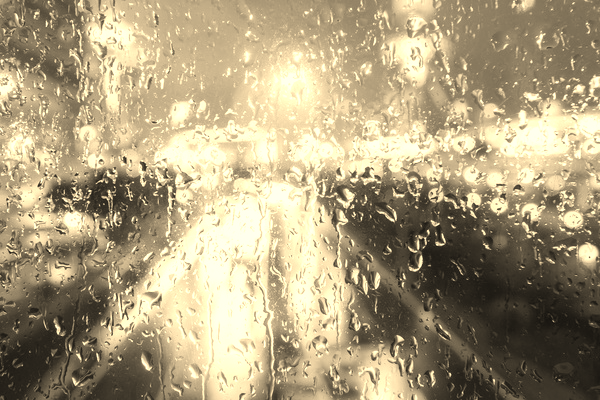

In [3]:
from instapy.cython_filters import *
grayscale_image = cython_color2sepia(pixels)
#grayscale_image = grayscale_image.astype("uint8")
Image.fromarray(grayscale_image)


In [35]:

sepia_matrix = np.asarray([
    [ 0.393, 0.769, 0.189],
    [ 0.349, 0.686, 0.168],
    [ 0.272, 0.534, 0.131],
])
sep = pixels[0,0]*sepia_matrix
print(sep)
np.sum(sep, axis=1)

[[ 24.759 110.736  47.439]
 [ 21.987  98.784  42.168]
 [ 17.136  76.896  32.881]]


array([182.934, 162.939, 126.913])

In [37]:
pixels[0,0]

array([ 63, 144, 251], dtype=uint8)

In [39]:
im = np.empty_like(pixels)
for i in range(len(pixels)):
    for j in range(len(pixels[i])): 
        im[i,j,:] = np.clip(np.sum(pixels[i,j,:]*sepia_matrix,axis=1),a_min=0,a_max=255)
    #np.sum(sep, axis=1)

im = im.astype("uint8")

In [23]:
im = np.empty_like(pixels)
for i in range(len(pixels)):
    for j in range(len(pixels[i])):
        for n in range(3):
             im[i,j,n] = min(255,sum([p * s for p,s in zip(sepia_matrix[n],pixels[i,j])]))

#im = im.astype("uint8")

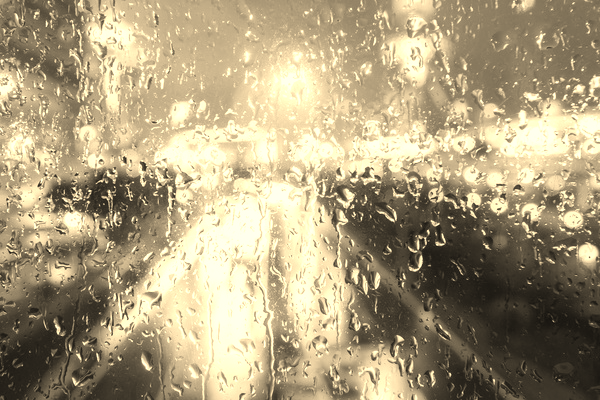

In [62]:
sepia_image= numba_color2sepia(pixels)
sepia_image = sepia_image.astype("uint8")
Image.fromarray(sepia_image)

In [63]:
%timeit  numba_color2sepia(pixels)

91.4 ms ± 574 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [3]:
%load_ext Cython

In [13]:
%%cython -a
import numpy as np
cimport numpy as np

cdef clip_to_255(double val):
    cdef int clipval = 255
    if val > clipval:
        return clipval
    else:
        return val

def cython_color2sepia(unsigned char[:,:,:] image):
    """Convert rgb pixel array to sepia

    Args:
        image (np.array)
    Returns:
        np.array: gray_image
    """

    cdef int nx = image.shape[1]
    cdef int ny = image.shape[0]

    cdef unsigned char[:,:,:] sepia_image = np.empty((ny,nx,3), dtype=np.uint8)

    cdef double[:,:] sepia_matrix = np.asarray(
        [
            [0.393, 0.769, 0.189],
            [0.349, 0.686, 0.168],
            [0.272, 0.534, 0.131],
        ]
    )
    cdef int i,j,n,m
    cdef double tmp

    for i in range(ny):
        for j in range(nx):
            for n in range(3):
                tmp = 0
                for m in range(3):
                    tmp = tmp + sepia_matrix[n, m] * image[i, j, m]
                
                sepia_image[i, j, n] = <unsigned char>min(tmp,255)
    
    return np.asarray(sepia_image)

In file included from /home/oliverif/.pyenv/versions/3.10.5/envs/dev/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948,
                 from /home/oliverif/.pyenv/versions/3.10.5/envs/dev/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/oliverif/.pyenv/versions/3.10.5/envs/dev/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/oliverif/.cache/ipython/cython/_cython_magic_c7e0018f563911dd04a9a5efdc12d3b9.c:776:
/home/oliverif/.pyenv/versions/3.10.5/envs/dev/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
/home/oliverif/.cache/ipython/cython/_cython_magic_c7e0018f563911dd04a9a5efdc12d3b9.c:2684:18: warning: ‘__pyx_f_46_cyth